## Load Data

In [10]:
import pandas as pd
import json

# Load the database
db = pd.read_csv("/media/george-vengrovski/Extreme SSD/database.csv")

# Function to convert onsets/offsets to seconds
def convert_to_seconds(onsets_offsets):
    return {k: [[onset/1000, offset/1000] for onset, offset in v] 
            for k, v in onsets_offsets.items()}

# Convert 'syllable_onsets/offsets' column from JSON strings to Python objects and convert to seconds
db['syllable_onsets/offsets'] = db['syllable_onsets/offsets'].apply(json.loads).apply(convert_to_seconds)

# Extract date and time information from file_name
db['datetime'] = db['file_name'].str.extract(r'(\d+_\d+_\d+_\d+_\d+)\.wav$')
db[['month', 'day', 'hour', 'minute', 'second']] = db['datetime'].str.split('_', expand=True).astype(int)

# Display the first few rows and data info
print(db.head())
print(db.info())

# Print a sample of the converted syllable_onsets/offsets for verification
print("\nSample of converted syllable_onsets/offsets:")
print(db['syllable_onsets/offsets'].iloc[0])

                                           file_name  song_present  \
0  /media/rose/Extreme SSD/20240726_All_Area_X_Le...          True   
1  /media/rose/Extreme SSD/20240726_All_Area_X_Le...          True   
2  /media/rose/Extreme SSD/20240726_All_Area_X_Le...          True   
3  /media/rose/Extreme SSD/20240726_All_Area_X_Le...          True   
4  /media/rose/Extreme SSD/20240726_All_Area_X_Le...          True   

                             syllable_onsets/offsets    datetime  month  day  \
0  {'8': [[10.971428571428572, 11.00625850340136]...  3_4_9_0_28      3    4   
1  {'9': [[14.44281179138322, 14.454421768707483]...  3_4_9_0_38      3    4   
2  {'9': [[4.806530612244898, 4.81814058956916], ...   3_4_9_1_1      3    4   
3  {'8': [[19.87628117913832, 19.922721088435374]...  3_4_9_1_30      3    4   
4  {'11': [[4.667210884353742, 4.6788208616780045...  3_4_9_1_48      3    4   

   hour  minute  second  
0     9       0      28  
1     9       0      38  
2     9       1     

## Calculate Quantity of Songs Over Days

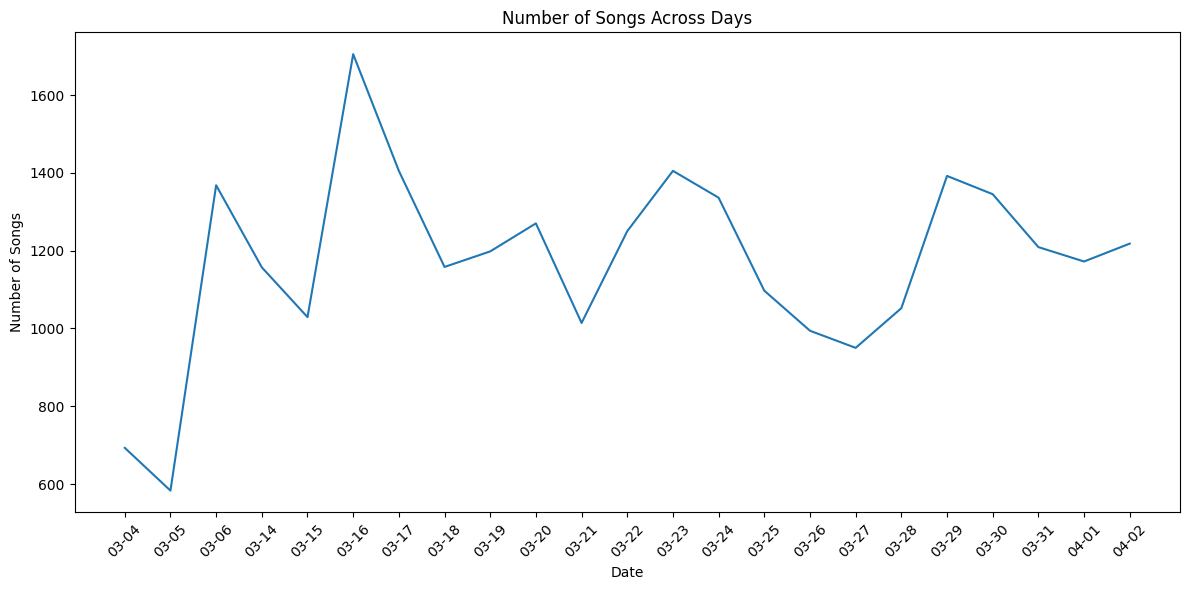

Total number of songs: 27000
Average songs per day: 1173.9130434782608
Day with most songs: date          1900-03-16 00:00:00
song_count                   1705
Name: 5, dtype: object
Day with least songs: date          1900-03-05 00:00:00
song_count                    583
Name: 1, dtype: object


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'db' is already loaded and processed as in the previous code block

# Convert month and day to a date
db['date'] = pd.to_datetime(db['month'].astype(str) + '-' + db['day'].astype(str), format='%m-%d')

# Count the number of songs per day
songs_per_day = db.groupby('date').size().reset_index(name='song_count')

# Sort by date
songs_per_day = songs_per_day.sort_values('date')

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(songs_per_day['date'].dt.strftime('%m-%d'), songs_per_day['song_count'])
plt.title('Number of Songs Across Days')
plt.xlabel('Date')
plt.ylabel('Number of Songs')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print summary statistics
print("Total number of songs:", songs_per_day['song_count'].sum())
print("Average songs per day:", songs_per_day['song_count'].mean())
print("Day with most songs:", songs_per_day.loc[songs_per_day['song_count'].idxmax()])
print("Day with least songs:", songs_per_day.loc[songs_per_day['song_count'].idxmin()])

Original labels shape: (167736,)
Smoothed labels shape: (167736,)

Unique labels in original data: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 32 33 34 35 36 37]
Unique labels in smoothed data: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 32 33 34 35 36 37]

Percentage of data points that changed: 26.10%

Smoothed labels saved to 'smoothed_labels.npz'


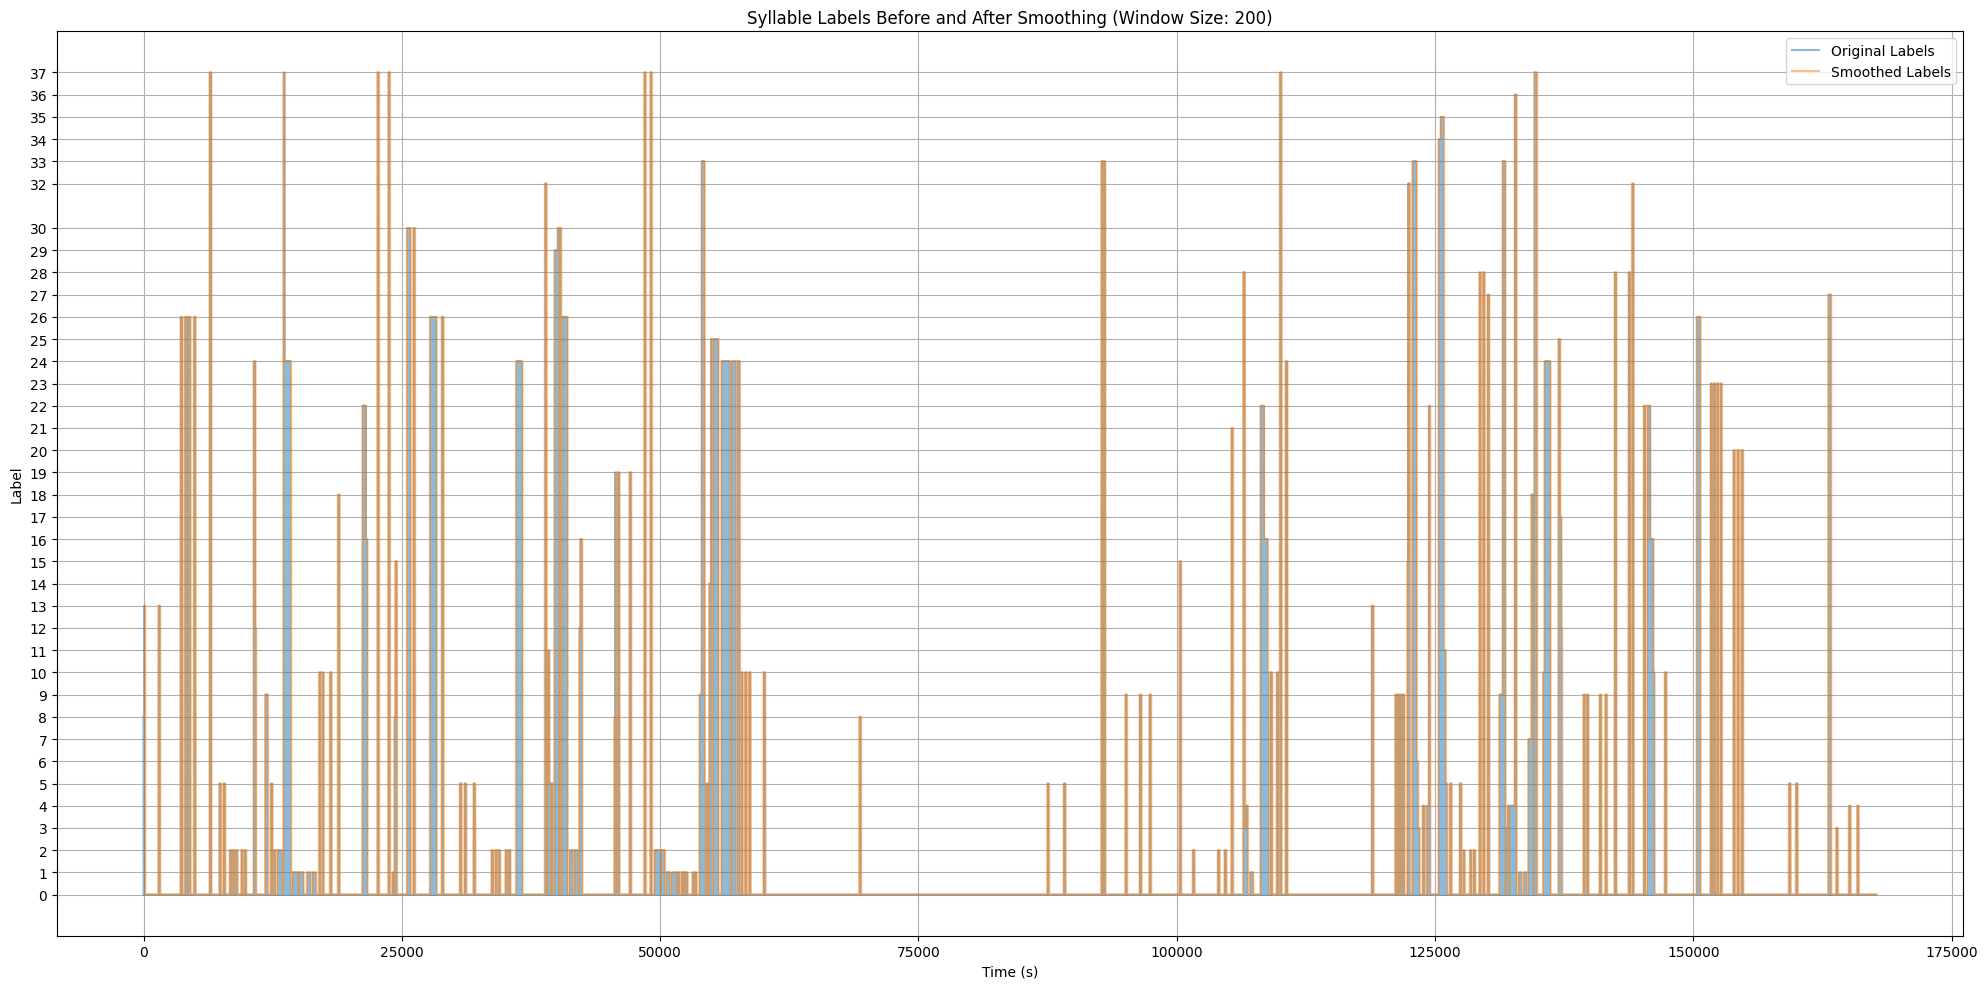


Plot saved as 'labels_comparison.png'


In [12]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

def smooth_labels(labels, window_size):
    smoothed_labels = np.copy(labels)
    for i in range(len(labels)):
        start = max(0, i - window_size // 2)
        end = min(len(labels), i + window_size // 2)
        window = labels[start:end]
        window = window[window != 0]  # Exclude silence (0) from the most common calculation
        if len(window) > 0:
            most_common = Counter(window).most_common(1)[0][0]
            smoothed_labels[i] = most_common
        else:
            smoothed_labels[i] = labels[i]
    return smoothed_labels

# Assuming 'db' is your pandas DataFrame
# Create a timeline of syllables with silence (0) between them
timeline = []
for _, row in db.head(50).iterrows():  # Only process the first 1000 songs
    onsets_offsets = row['syllable_onsets/offsets']
    for syllable, times in onsets_offsets.items():
        for onset, offset in times:
            timeline.extend([0] * int(onset))  # Silence before syllable
            timeline.extend([int(syllable)] * (int(offset) - int(onset)))  # Syllable
    timeline.extend([0] * 1000)  # Add 1 second of silence between songs

hdbscan_labels = np.array(timeline)

# Set the window size
window_size = 200

# Apply the sliding window smoothing
smoothed_labels = smooth_labels(hdbscan_labels, window_size)

# Print some statistics
print(f"Original labels shape: {hdbscan_labels.shape}")
print(f"Smoothed labels shape: {smoothed_labels.shape}")
print(f"\nUnique labels in original data: {np.unique(hdbscan_labels)}")
print(f"Unique labels in smoothed data: {np.unique(smoothed_labels)}")

# Calculate and print the percentage of data points that changed
changed_percentage = (hdbscan_labels != smoothed_labels).mean() * 100
print(f"\nPercentage of data points that changed: {changed_percentage:.2f}%")

# Save the smoothed labels
np.savez('smoothed_labels.npz', smoothed_labels=smoothed_labels)
print("\nSmoothed labels saved to 'smoothed_labels.npz'")

# Plotting
plt.figure(figsize=(20, 10))
plt.plot(hdbscan_labels[:500000], label='Original Labels', alpha=0.5)
plt.plot(smoothed_labels[:500000], label='Smoothed Labels', alpha=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Label')
plt.title(f'Syllable Labels Before and After Smoothing (Window Size: {window_size})')
plt.legend()
plt.grid(True)

# Adjust y-axis to show integer ticks
y_ticks = sorted(list(set(np.unique(hdbscan_labels)) | set(np.unique(smoothed_labels))))
plt.yticks(y_ticks)

plt.tight_layout()
plt.savefig('labels_comparison.png', dpi=300)
plt.show()

print("\nPlot saved as 'labels_comparison.png'")

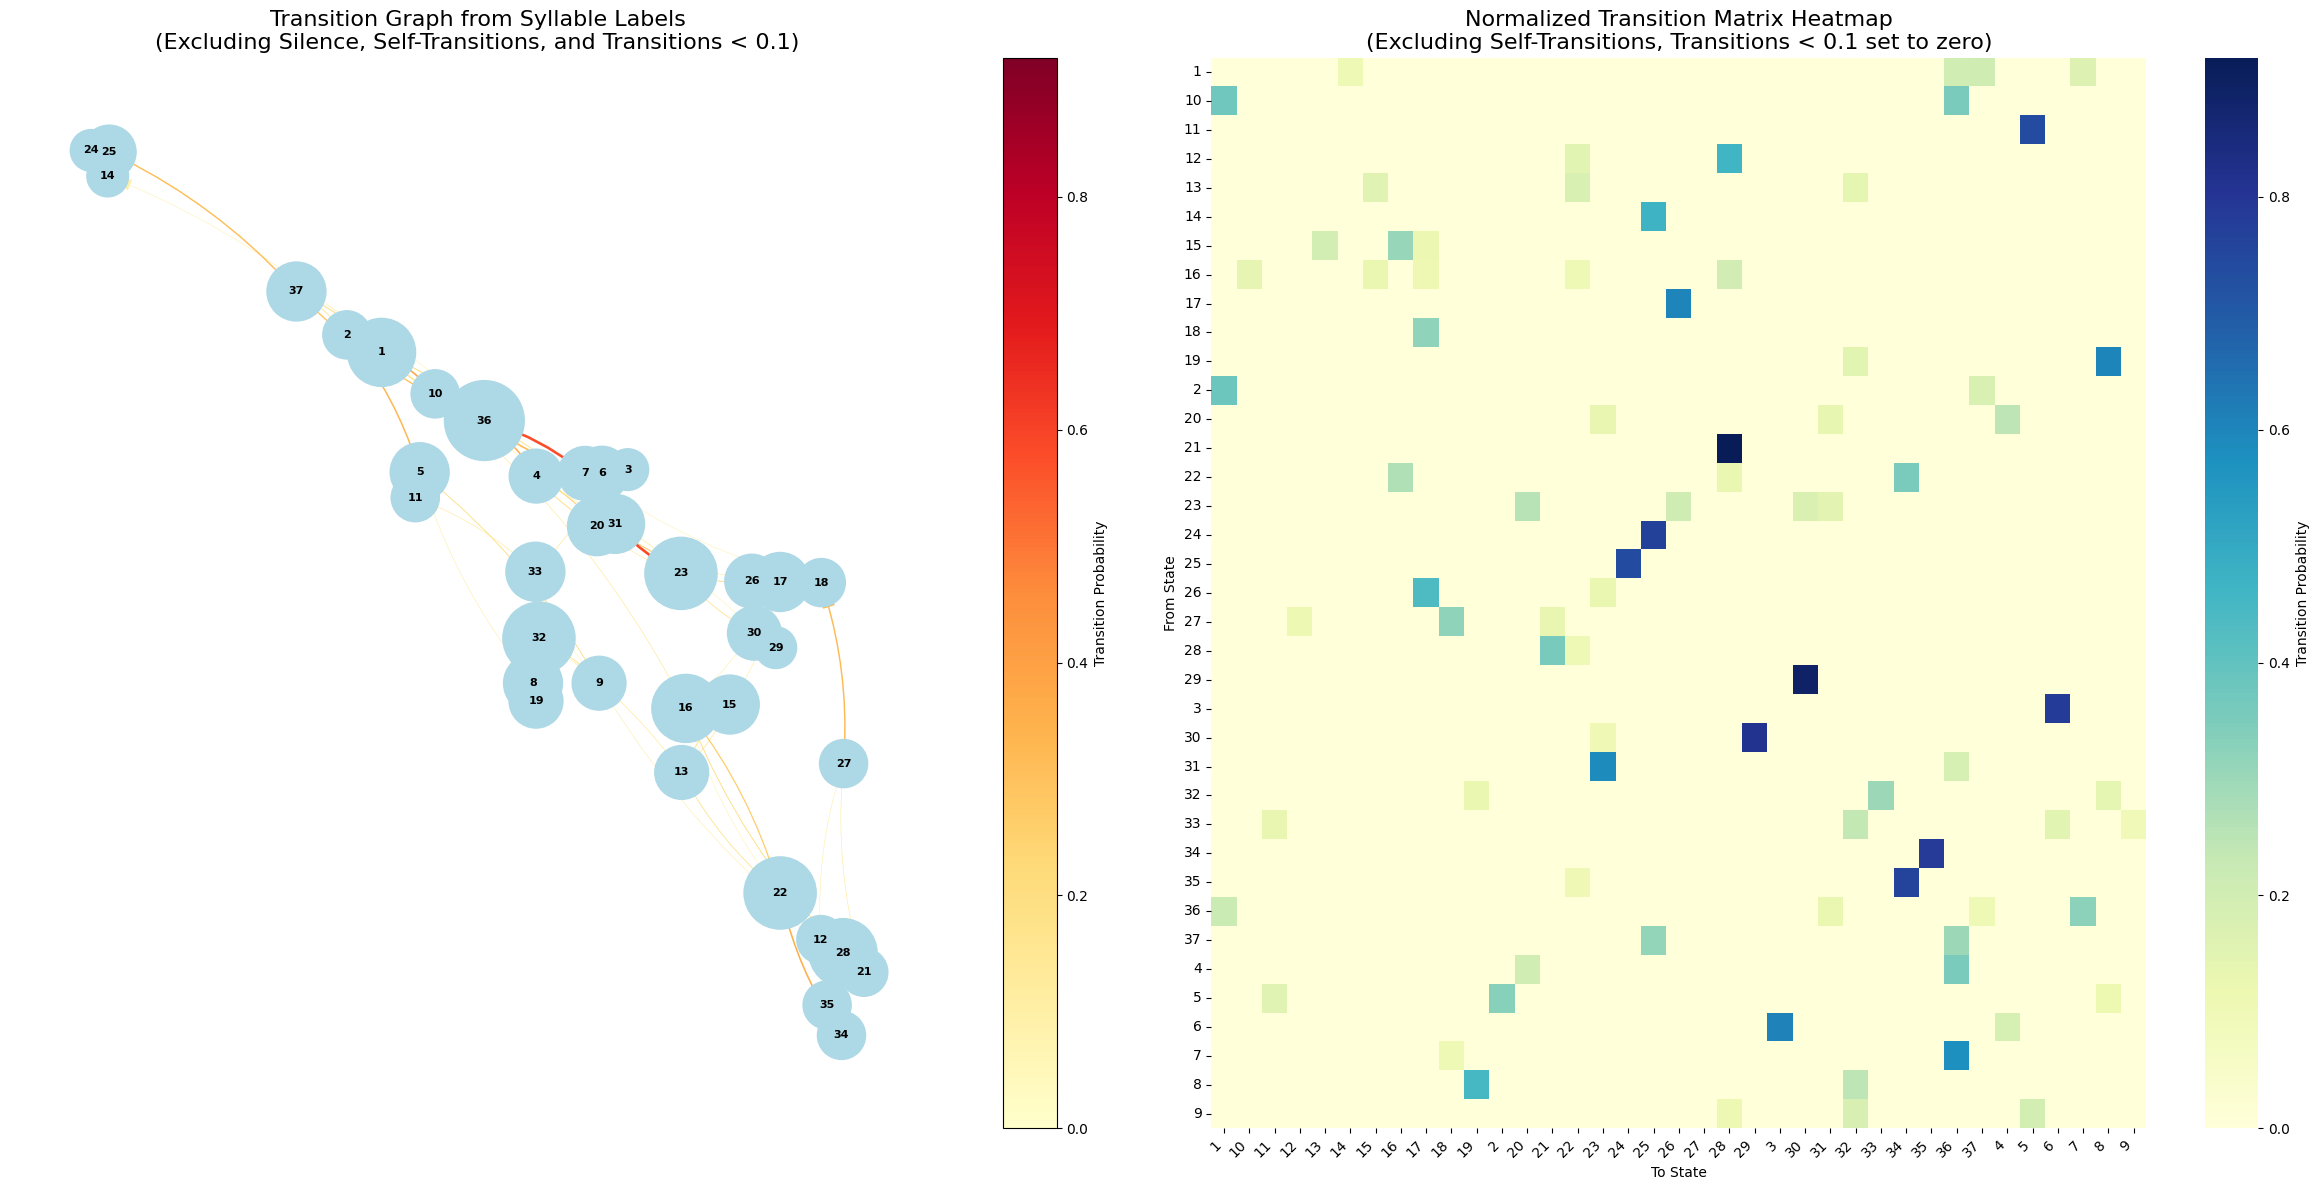

In [14]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from collections import Counter

def calculate_transition_matrix(db):
    transitions = []
    unique_labels = set()

    for _, row in db.iterrows():
        file_transitions = []
        syllables = row['syllable_onsets/offsets']
        sorted_syllables = sorted([(onset, offset, label) for label, times in syllables.items() for onset, offset in times])
        
        for i in range(len(sorted_syllables) - 1):
            current_label = sorted_syllables[i][2]
            next_label = sorted_syllables[i+1][2]
            if current_label != 'silence' and next_label != 'silence' and current_label != next_label:
                file_transitions.append((current_label, next_label))
                unique_labels.add(current_label)
                unique_labels.add(next_label)
        
        transitions.extend(file_transitions)

    unique_labels = sorted(list(unique_labels))
    transition_matrix = np.zeros((len(unique_labels), len(unique_labels)))

    for from_label, to_label in transitions:
        i = unique_labels.index(from_label)
        j = unique_labels.index(to_label)
        transition_matrix[i, j] += 1

    # Normalize the transition matrix
    row_sums = transition_matrix.sum(axis=1)
    transition_matrix_norm = np.divide(transition_matrix, row_sums[:, np.newaxis], where=row_sums[:, np.newaxis]!=0)

    # Set small transitions to zero for better visualization
    transition_matrix_norm[transition_matrix_norm < 0.1] = 0

    return transition_matrix_norm, unique_labels

# Calculate the transition matrix
transition_matrix_norm, unique_labels = calculate_transition_matrix(db)

# Create graph
G = nx.DiGraph()

# Add nodes
for label in unique_labels:
    G.add_node(label)

# Add edges (excluding self-edges)
for i, from_label in enumerate(unique_labels):
    for j, to_label in enumerate(unique_labels):
        if i != j:  # Exclude self-edges
            weight = transition_matrix_norm[i, j]
            if weight > 0:
                G.add_edge(from_label, to_label, weight=weight)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12))

# Improve graph layout
pos = nx.spring_layout(G, k=0.1, iterations=500)

# Adjust node sizes based on their degree
node_sizes = [300 * (1 + G.degree(node)) for node in G.nodes()]

# Adjust edge widths based on their weight
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
max_weight = max(edge_weights) if edge_weights else 1
normalized_weights = [w / max_weight for w in edge_weights]

# Use a colormap for edges
edge_colors = plt.cm.YlOrRd(normalized_weights)

# Plot graph with improved styling
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='lightblue', ax=ax1)
nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold', ax=ax1)
nx.draw_networkx_edges(G, pos, width=[w * 3 for w in normalized_weights], 
                       edge_color=edge_colors, arrows=True, 
                       arrowsize=20, ax=ax1, connectionstyle="arc3,rad=0.1")

# Add a colorbar for edge weights
sm = plt.cm.ScalarMappable(cmap=plt.cm.YlOrRd, norm=plt.Normalize(vmin=0, vmax=max_weight))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax1, label='Transition Probability')

ax1.set_title("Transition Graph from Syllable Labels\n(Excluding Silence, Self-Transitions, and Transitions < 0.1)", fontsize=16)
ax1.axis('off')

# Plot transition matrix as heatmap without numbers
sns.heatmap(transition_matrix_norm, cmap='YlGnBu', ax=ax2, cbar_kws={'label': 'Transition Probability'})
ax2.set_title("Normalized Transition Matrix Heatmap\n(Excluding Self-Transitions, Transitions < 0.1 set to zero)", fontsize=16)
ax2.set_xlabel("To State")
ax2.set_ylabel("From State")
ax2.set_xticklabels(unique_labels, rotation=45, ha='right')
ax2.set_yticklabels(unique_labels, rotation=0)

plt.tight_layout()
plt.show()

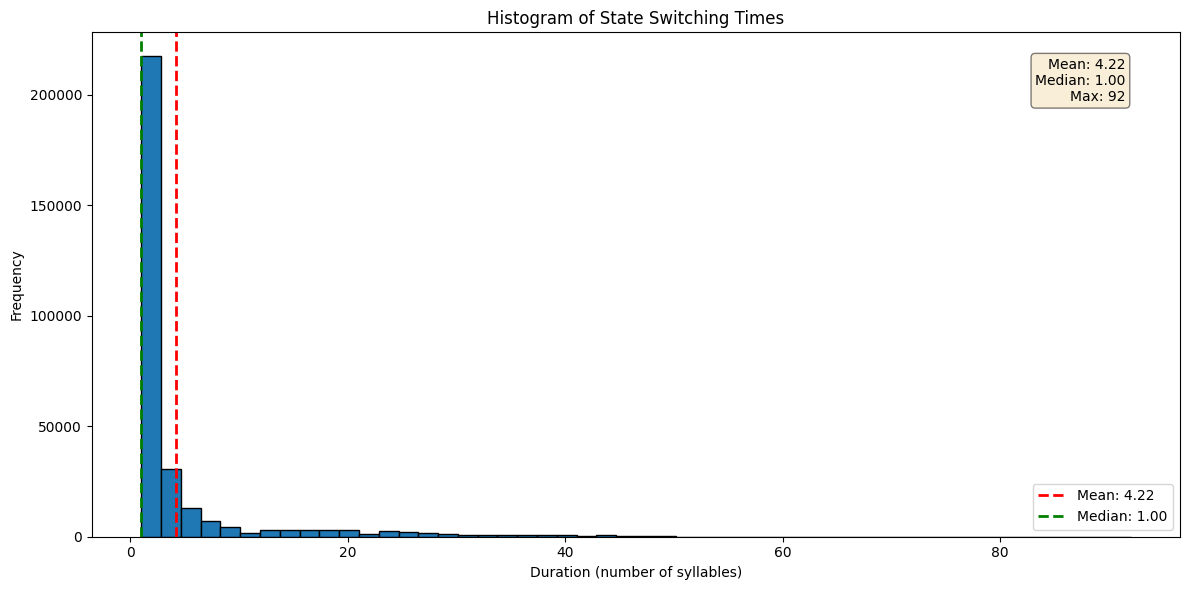

Mean switching time: 4.22
Median switching time: 1.00
Maximum switching time: 92
Total number of switches: 305277


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Assuming db is your loaded DataFrame
# We'll create a list of all syllable labels in order

all_labels = []
for _, row in db.iterrows():
    syllables = row['syllable_onsets/offsets']
    sorted_syllables = sorted([(onset, label) for label, times in syllables.items() for onset, _ in times])
    all_labels.extend([label for _, label in sorted_syllables])

# Calculate switching times
switching_times = []
current_state = all_labels[0]
current_duration = 1

for label in all_labels[1:]:
    if label == current_state:
        current_duration += 1
    else:
        switching_times.append(current_duration)
        current_state = label
        current_duration = 1

# Add the last state duration if it hasn't switched at the end
if current_duration > 1:
    switching_times.append(current_duration)

# Convert to numpy array for easier manipulation
switching_times = np.array(switching_times)

# Calculate some statistics
mean_time = np.mean(switching_times)
median_time = np.median(switching_times)
max_time = np.max(switching_times)

# Create the histogram
plt.figure(figsize=(12, 6))
plt.hist(switching_times, bins=50, edgecolor='black')
plt.title('Histogram of State Switching Times')
plt.xlabel('Duration (number of syllables)')
plt.ylabel('Frequency')

# Add vertical lines for mean and median
plt.axvline(mean_time, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_time:.2f}')
plt.axvline(median_time, color='g', linestyle='dashed', linewidth=2, label=f'Median: {median_time:.2f}')

plt.legend()

# Add text box with statistics
stats_text = f'Mean: {mean_time:.2f}\nMedian: {median_time:.2f}\nMax: {max_time}'
plt.text(0.95, 0.95, stats_text, transform=plt.gca().transAxes, verticalalignment='top',
         horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('switching_times_histogram.png', dpi=300)
plt.show()

print(f"Mean switching time: {mean_time:.2f}")
print(f"Median switching time: {median_time:.2f}")
print(f"Maximum switching time: {max_time}")
print(f"Total number of switches: {len(switching_times)}")